# Arbitrage Betting Strategies
---
- Author: Matthew Thoomkuzhy

- Date: 29/01/2025

- Aim: To investigate the nature of arbitrage opportunities over the smaple, to inform and devise an arbitrage betting strategy (this will be bakctested in NB05)
---

# 1. Introduction

This notebook will largely consist of exploratory daata analysis where we explore and identify patterns involving arbitrage opportunities for premier league matches from 2020 to 2025

**Key questions I aim to answer:**



- How has the prevelance of arbitrage opportunities changed over time?, is it periodic? (i.e. more opportunites at the start of every season)


- When arbitrage opportunities are present what is the distribution of odds differences among outcomes, is there a clear favourite or are the games implicitly 'close'


- How do full time results vary with odds differences, can this information be used to inform when to use biased vs unbiased arbitrage?



---
# 2. Importing Libraries

In [175]:
from functions import process_row , process_odds_data # from functions.py
import pandas as pd
from sqlalchemy import create_engine
from lets_plot import * 
from lets_plot import ggsave
from IPython.display import SVG
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns

---
# 3.  Obtaining DF from DB

In [176]:
engine = create_engine('sqlite:///../data/sports_odds.db')
odds_df = pd.read_sql('SELECT * FROM historical_odds', con=engine)
results_df = pd.read_sql('SELECT * FROM match_results', con=engine)

# Using imported functions to get DF
merged_df = process_odds_data(odds_df, results_df,process_row)
merged_df 


,fixture_id,Date,home_team,away_team,FTR,max_home,home_bookmaker,max_away,away_bookmaker,max_draw,draw_bookmaker
0,AVLSHU170620,17/06/2020,Aston Villa,Sheffield United,D,3.35,Unibet,2.41,Marathon Bet,3.52,Marathon Bet
1,MCIARS170620,17/06/2020,Manchester City,Arsenal,H,1.39,Marathon Bet,8.70,Marathon Bet,5.95,Marathon Bet
2,TOTMUN190620,19/06/2020,Tottenham Hotspur,Manchester United,D,2.88,Betfair,2.64,Marathon Bet,3.70,Marathon Bet
3,WATLEI200620,20/06/2020,Watford,Leicester City,D,3.52,Marathon Bet,2.22,Marathon Bet,3.75,Marathon Bet
4,WHUWOL200620,20/06/2020,West Ham United,Wolverhampton Wanderers,A,3.70,Betfair,2.23,Marathon Bet,3.60,Marathon Bet
...,...,...,...,...,...,...,...,...,...,...,...
1777,FULARS081224,08/12/2024,Fulham,Arsenal,D,6.40,Smarkets,1.62,BoyleSports,4.33,Sky Bet
1778,IPSBOU081224,08/12/2024,Ipswich Town,Bournemouth,A,3.20,Paddy Power,2.20,Smarkets,3.90,Betfair
1779,LEIBHA081224,08/12/2024,Leicester City,Brighton and Hove Albion,D,5.00,Paddy Power,1.73,BoyleSports,4.40,Coral
1780,TOTCHE081224,08/12/2024,Tottenham Hotspur,Chelsea,A,2.30,Paddy Power,3.10,Smarkets,3.75,Sky Bet


---
# 4.) prevalence of arbitrage opportunities over time

Now I am going to be implementing code logic for arbitrage opportunities,
grouping opportunities for each event by commence time and
then plotting a time series graph for the prevalence of arbitrage opportunities over time

**Code for arbitrage logic**:

- I implement the formula (1/oddsH + 1/oddsD + 1/oddsA) for each event and check if < or > 1, if less than one, then an arbitrage opportunity exists.

C:\Users\jogim\AppData\Local\Temp\ipykernel_13232\3093376532.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  arb_freq = df.groupby("Date").apply(check_arbitrage)


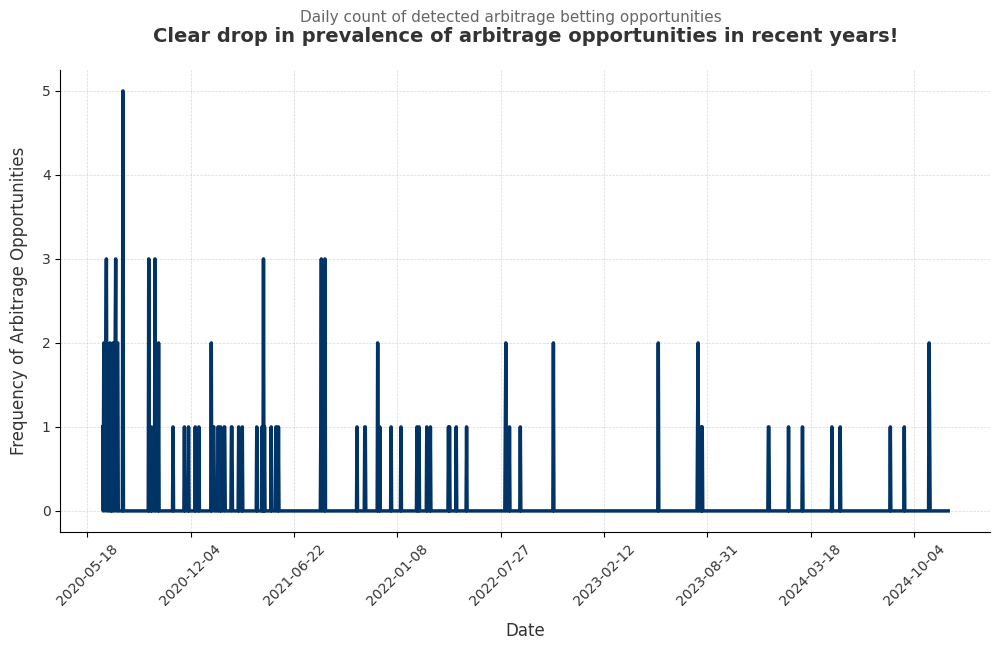

In [177]:


def plot_arbitrage_over_time(df):

    # Ensure required columns exist
    required_columns = {"Date", "max_home", "max_away", "max_draw"}
    if not required_columns.issubset(df.columns):
        raise ValueError(f"Missing required columns: {required_columns - set(df.columns)}")

    # Copy dataframe to avoid modifying the original
    df = df.copy()

    # Convert Date column to datetime format
    df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y")

    # Filter out invalid odds (0 or NaN)
    df = df.dropna(subset=["max_home", "max_away", "max_draw"])
    df = df[(df["max_home"] > 0) & (df["max_away"] > 0) & (df["max_draw"] > 0)]

    # **Optimized arbitrage detection using groupby + apply**
    def check_arbitrage(group):
        
        arb_values = (1 / group["max_home"]).combine(
            (1 / group["max_away"]), func=lambda x, y: x + y
        ).combine(
            (1 / group["max_draw"]), func=lambda x, y: x + y
        )
        return (arb_values < 1).sum()  # Count arbitrage opportunities in the group

    # Apply group-wise arbitrage detection
    arb_freq = df.groupby("Date").apply(check_arbitrage)

    # Ensure all dates are represented in the time series
    arb_freq = arb_freq.resample("D").sum().fillna(0)

    # Plotting
    plt.figure(figsize=(12, 6))

    plt.plot(arb_freq.index, arb_freq.values, color="#003366", linewidth=2.5)

    # Titles and labels
    plt.title("Clear drop in prevalence of arbitrage opportunities in recent years!", fontsize=14, fontweight="bold", pad=20, color="#333333")
    plt.suptitle("Daily count of detected arbitrage betting opportunities", fontsize=11, color="#666666")

    plt.xlabel("Date", fontsize=12, color="#333333", labelpad=10)
    plt.ylabel("Frequency of Arbitrage Opportunities", fontsize=12, color="#333333", labelpad=10)

    # Grid with subtlety
    plt.grid(which="major", linestyle="--", linewidth=0.5, alpha=0.5)

    # Adjust x-axis for cleaner date formatting
    plt.xticks(rotation=45, fontsize=10, color="#333333")
    plt.yticks(fontsize=10, color="#333333")
    plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(10))  # Limits number of x-ticks

    # Remove chart border for cleaner look
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    
    # Save plot as a file
    plt.savefig("../data/visualisations/arb_betting_strategies/arb_opportunity_frequency.png", bbox_inches='tight')

    # Display the plot
    plt.show()
    


# Apply the function to the dataset
plot_arbitrage_over_time(merged_df)


### Insight: 

Visually we can see there has been a large dropoff in the number of abritrage opportunities detected daily. Previously there were many days where 2+, 3+ daily opportunities where present whereas now there are long periods where no opportunities are detected at all!

**Informing NB05 strategy:** The data shows arb may yield lucrative for 2020 but for more recent years the effectvieness of arbitrage is lower

**this may suggests the bookies are becoming more co-ordinated in their odds offerred and arbitrage is dying**

To investigate this further I want to investigate the **profit margins of arbitrage**, a fall in profit margins from arbitrage could be indiciative of lower odds deviation between bookmakers:

# 5.) Distribution of arbitrage profit margins over time

---

1. To investigate how faily profit margins are varying I have worked out the most profitable event in each day of the sample.

2. I then used this as an indication of the profitability of that day (days wiht no arb opportunities would be zero)

3. I have decided against using a geometric total for days with >1 arb. ie. multiplying profit margins for each event in that day together. This is as events ususally clash in time due to match scheduling, therefore its impossible to bet on both events simultaneously wihout splitting funds from an inital bankroll

**Logic for profit margins**


I implement the formula 100 x  (1- (1/oddsH + 1/oddsD + 1oddsA)) for each arbitrage event to work out the profit margin (%) of that event

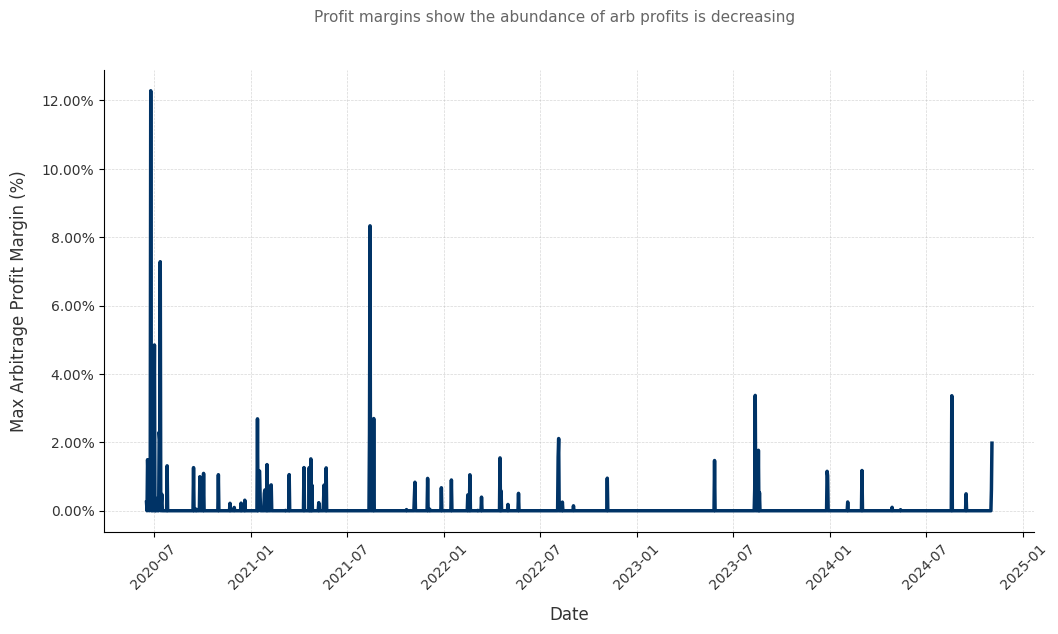

In [178]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_max_arbitrage_profitability(df):

    required_columns = {"Date", "max_home", "max_away", "max_draw"}
    if not required_columns.issubset(df.columns):
        raise ValueError(f"Missing required columns: {required_columns - set(df.columns)}")

    df = df.copy()
    df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y")

    df = df.dropna(subset=["max_home", "max_away", "max_draw"])
    df = df[(df["max_home"] > 0) & (df["max_away"] > 0) & (df["max_draw"] > 0)]

    df["arbitrage_margin"] = 1 - ((1 / df["max_home"]) + (1 / df["max_away"]) + (1 / df["max_draw"]))
    df = df[df["arbitrage_margin"] > 0]

    # Get the most profitable arbitrage event per day
    daily_max_profit = df.groupby("Date")["arbitrage_margin"].max()

    # Reindex to include all days, filling missing values with 0
    daily_max_profit = daily_max_profit.reindex(pd.date_range(df["Date"].min(), df["Date"].max()), fill_value=0)

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(daily_max_profit.index, daily_max_profit.values, color="#003366", linewidth=2.5)

    plt.suptitle("Profit margins show the abundance of arb profits is decreasing", fontsize=11, color="#666666")

    plt.xlabel("Date", fontsize=12, color="#333333", labelpad=10)
    plt.ylabel("Max Arbitrage Profit Margin (%)", fontsize=12, color="#333333", labelpad=10)

    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x*100:.2f}%"))
    plt.grid(which="major", linestyle="--", linewidth=0.5, alpha=0.5)

    plt.xticks(rotation=45, fontsize=10, color="#333333")
    plt.yticks(fontsize=10, color="#333333")
    

    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.savefig("../data/visualisations/arb_betting_strategies/arbitrage_profit_margin_timeline.png", bbox_inches='tight')


plot_max_arbitrage_profitability(merged_df)


### Insight:

The existence of large arbitrage profit margins has diminished, as in 2020 many margins over 4% were present however these are long gone

However periodically we observe there is a spike in margins every year at a similar time, I want to investigate this further. I am going to generate a chart of opportunities by month

# 6.) Seasonality of arbitrage opportunities

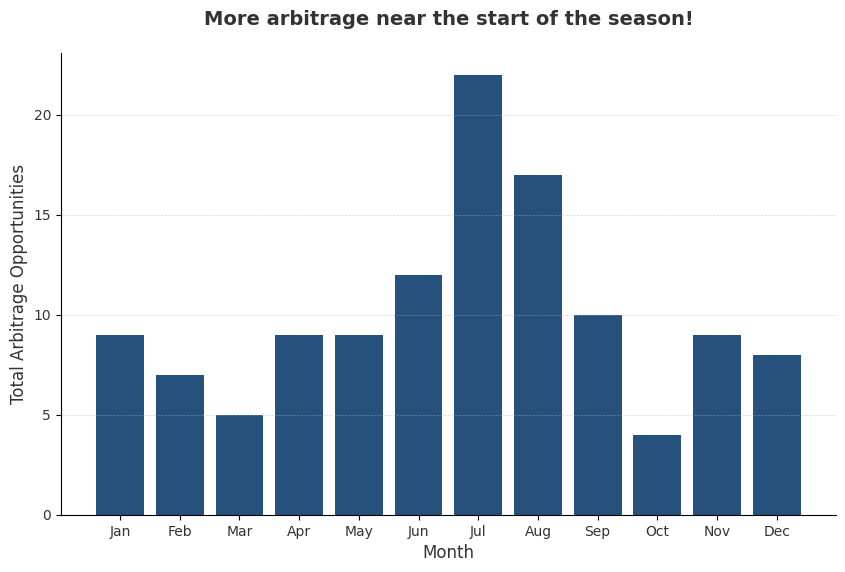

In [179]:


def plot_arbitrage_opportunities_by_month(df):

    required_columns = {"Date", "max_home", "max_away", "max_draw"}
    if not required_columns.issubset(df.columns):
        raise ValueError(f"Missing required columns: {required_columns - set(df.columns)}")

    df = df.copy()
    df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y")

    df = df.dropna(subset=["max_home", "max_away", "max_draw"])
    df = df[(df["max_home"] > 0) & (df["max_away"] > 0) & (df["max_draw"] > 0)]

    df["arbitrage_margin"] = 1 - ((1 / df["max_home"]) + (1 / df["max_away"]) + (1 / df["max_draw"]))
    df["Month"] = df["Date"].dt.month  # Extract month as a number

    # Count arbitrage occurrences per month (regardless of year)
    monthly_arb_counts = df[df["arbitrage_margin"] > 0]["Month"].value_counts().sort_index()

    # Define month names for better readability
    month_labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

    # Plot
    plt.figure(figsize=(10, 6))
    plt.bar(month_labels, monthly_arb_counts, color="#003366", alpha=0.85)

    plt.title("More arbitrage near the start of the season!", fontsize=14, fontweight="bold", pad=20, color="#333333")
    plt.xlabel("Month", fontsize=12, color="#333333")
    plt.ylabel("Total Arbitrage Opportunities", fontsize=12, color="#333333")

    plt.grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.5)
    plt.xticks(fontsize=10, color="#333333")
    plt.yticks(fontsize=10, color="#333333")

    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    
    # Save plot as a file
    plt.savefig("../data/visualisations/arb_betting_strategies/arbitrage_opportunities_by_month.png", bbox_inches='tight')

    plt.show()
    


# Example Usage:
plot_arbitrage_opportunities_by_month(merged_df)


### Insight:

The clear spike in the number of arbitrage opportunities in June July and August (the 3 most popular months) implies that **arbitrage is most effective at the start of the season**

This is likely due to **greater uncertainty at the start of the season** as to who has a stronger and weaker team, and less recent form data means that bookmakers will show **greater deviations in pricing odds**.

**Informing NB05 strategy:** The data shows that a higher weighting should be placed on arbitrage during the early season months due to their increased frequency

I want to further investigate deviations in pricing odds.

---
# 7.) Nature of odds pricing in arbitrage events

First I begin by calculating the size of the sample for arbitrage games

In [180]:
# Ensure arbitrage margin is calculated
merged_df["arbitrage_margin"] = 1 - ((1 / merged_df["max_home"]) + (1 / merged_df["max_away"]) + (1 / merged_df["max_draw"]))

# Ensure only valid arbitrage opportunities are counted
total_arb_opportunities = (merged_df["arbitrage_margin"] > 0).sum()

print("Total Arbitrage Opportunities:", total_arb_opportunities)


Total Arbitrage Opportunities: 121


121 is a sufficiently large sample (of arbitrage matches) to draw observations regarding the nature of arbitrage

First I want to investigate the odds difference for arbitrage events by plottign the desnity of odds difference for arbitrage events

**Logic for odds difference**:

The odds difference has been calculated by doign abs(home odds - away odds) the lower the odds difference is, this implies the game is closer and tehre isn't a 'favourite team'. Thus i will be using the odds difference as a measure of the closeness of games

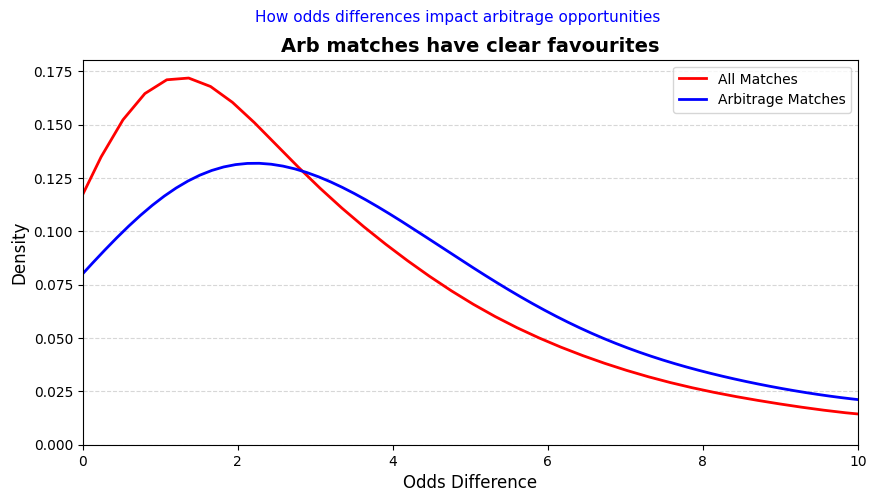

In [181]:

# Copy and clean the dataframe
merged_df = merged_df.copy()
merged_df = merged_df.dropna(subset=["max_home", "max_away", "max_draw"])
merged_df = merged_df[(merged_df["max_home"] > 0) & (merged_df["max_away"] > 0) & (merged_df["max_draw"] > 0)]

# Calculate arbitrage margin
merged_df["arbitrage_margin"] = 1 - ((1 / merged_df["max_home"]) + (1 / merged_df["max_away"]) + (1 / merged_df["max_draw"]))

# Compute odds difference for all matches
merged_df['odds_difference'] = abs(merged_df['max_home'] - merged_df['max_away'])

# Filter only arbitrage events
arb_events_df = merged_df[merged_df["arbitrage_margin"] > 0].copy()

# Drop missing values and ensure 'odds_difference' is numeric
merged_df = merged_df.dropna(subset=['odds_difference'])
arb_events_df = arb_events_df.dropna(subset=['odds_difference'])

merged_df['odds_difference'] = pd.to_numeric(merged_df['odds_difference'])
arb_events_df['odds_difference'] = pd.to_numeric(arb_events_df['odds_difference'])

# Plot hollow density curves
plt.figure(figsize=(10, 5))

# Density of all matches (hollow red line)
sns.kdeplot(merged_df['odds_difference'], color='red', linewidth=2, label='All Matches')

# Density of arbitrage matches (hollow blue line)
sns.kdeplot(arb_events_df['odds_difference'], color='blue', linewidth=2, label='Arbitrage Matches')

# Formatting
plt.xlim(0, 10)
plt.xlabel("Odds Difference", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.title("Arb matches have clear favourites", fontsize=14, fontweight='bold')
plt.suptitle("How odds differences impact arbitrage opportunities", fontsize=11, color='blue')

# Add legend
plt.legend()

# Save plot to a file
plt.savefig("../data/visualisations/arb_betting_strategies/arbitrage_density.png", bbox_inches='tight')

# Show plot
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


### Insight:

Both matches and arbitrage matches follow a normal distribution

the peak of the arbitrage match density graph occurs further to the right, which suggests that **arbitrage matches occur where the odds difference is higher**, so there is a clear winner and loser

the peak also occurs higher, which suggests that odds deviate more between games for arbitrage events. Arbitrage events occur more commonly across a wider range of odds differences.

**This implies bookmakers compete on non-close games**

I want to look into this more concretely with statistsics:

In [182]:

# Calculate arbitrage margin
merged_df["arbitrage_margin"] = 1 - ((1 / merged_df["max_home"]) + (1 / merged_df["max_away"]) + (1 / merged_df["max_draw"]))

# Compute odds difference
merged_df["odds_difference"] = abs(merged_df["max_home"] - merged_df["max_away"])

# Separate arbitrage and non-arbitrage matches
arb_events_df = merged_df[merged_df["arbitrage_margin"] > 0].copy()  # Arbitrage matches
non_arb_events_df = merged_df[merged_df["arbitrage_margin"] <= 0].copy()  # Non-arbitrage matches

# Calculate mean and standard deviation for each distribution
stats = {
    "Distribution": ["All Matches", "Arbitrage Matches", "Non-Arbitrage Matches"],
    "Mean Odds Difference": [
        np.nanmean(merged_df['odds_difference']),
        np.nanmean(arb_events_df['odds_difference']),
        np.nanmean(non_arb_events_df['odds_difference'])
    ],
    "Standard Deviation": [
        np.nanstd(merged_df['odds_difference']),
        np.nanstd(arb_events_df['odds_difference']),
        np.nanstd(non_arb_events_df['odds_difference'])
    ]
}

# Convert to DataFrame and display
stats_df = pd.DataFrame(stats)
print(stats_df)


            Distribution  Mean Odds Difference  Standard Deviation
0            All Matches              3.871906            4.694607
1      Arbitrage Matches              4.430992            4.236917
2  Non-Arbitrage Matches              3.831104            4.723684


The table above shows an almost 0.5 greater odds difference for arb games, implying arb games have a clear winner and loser. 

It also shows a 0.5 smaller standard deviation implying odds are less widely varied, this implies that events with extreme odds sifferences are more likely to be 'arbable'

Now I want to investigate the nature of otucomes in regards to arb opportunities and odds differences, I will be usiong this to set thresholds for when to use biased vs non-biased arb in strategies

---
# 8.) When to use biased vs non - biased arb

To help devise a more successful strategy I want to find conditions in which biased arb vs non-biased arb will be more successful.

Unbiased arb involves betting in a way so that the same profit is made regardless of outcome. On the other hand, biased arb involves a 'triple or nothing approach' where more profit is made if the biased event occurs, but none is made if another event occurs 

by examining the FTR column relative to the odds differences of each event, I want to find out when it is optimal to employ biased arb rather than unbiased arb

C:\Users\jogim\AppData\Local\Temp\ipykernel_13232\3917386489.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  win_rates_all = merged_df.groupby("implied_prob_bin")["favorite_won"].mean().reset_index()
C:\Users\jogim\AppData\Local\Temp\ipykernel_13232\3917386489.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  win_rates_arb = arb_events_df.groupby("implied_prob_bin")["favorite_won"].mean().reset_index()


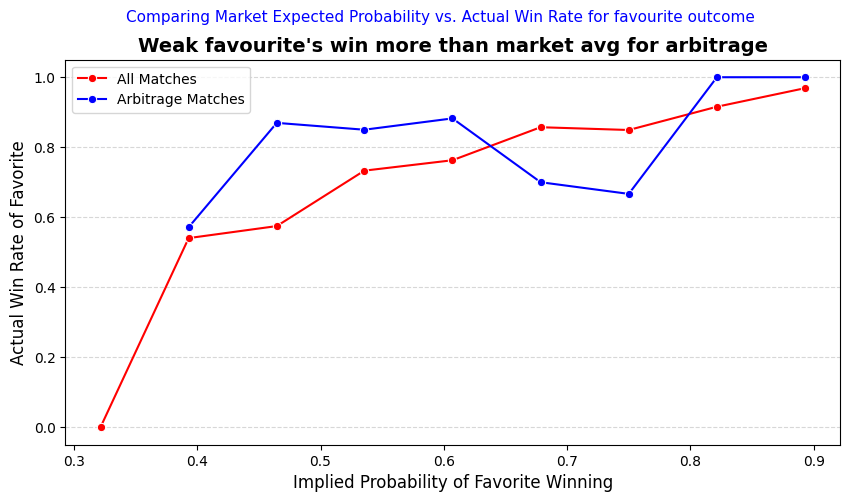

In [183]:


# ---- Load and Clean Data ----
# Ensure columns are numeric
for col in ["max_home", "max_away", "max_draw"]:
    merged_df[col] = pd.to_numeric(merged_df[col], errors="coerce")

# Drop missing values
merged_df = merged_df.dropna(subset=["max_home", "max_away", "max_draw", "FTR"])
merged_df = merged_df[(merged_df["max_home"] > 0) & (merged_df["max_away"] > 0) & (merged_df["max_draw"] > 0)]

# ---- Compute Arbitrage Margin ----
merged_df["arbitrage_margin"] = 1 - ((1 / merged_df["max_home"]) + (1 / merged_df["max_away"]) + (1 / merged_df["max_draw"]))

# ---- Explicitly Identify the Favorite (Lowest Decimal Odds) ----
merged_df["favorite_outcome"] = merged_df[["max_home", "max_away"]].idxmin(axis=1)  # Selects the team with the lowest odds

# Mapping the favorite to match result (excluding draws)
outcome_mapping = {"max_home": "H", "max_away": "A"}

# Assign whether the favorite won (exclude draws)
merged_df["favorite_won"] = merged_df.apply(
    lambda row: row["FTR"] == outcome_mapping.get(row["favorite_outcome"], None), axis=1
).astype(int)

# Exclude draws AFTER determining the favorite
merged_df = merged_df[merged_df["FTR"] != "D"]

# ---- Compute Implied Probability of Favorite Winning ----
merged_df["implied_prob_fav"] = 1 / merged_df[["max_home", "max_away"]].min(axis=1)

# ---- Split Data: Arbitrage Matches vs. All Matches ----
arb_events_df = merged_df[merged_df["arbitrage_margin"] > 0].copy()

# ---- Compute Win Rates by Implied Probability Bins (Using Broader Bins) ----
bins = np.linspace(0, 1, 15)  # 15 bins from 0% to 100% probability for more stability
merged_df["implied_prob_bin"] = pd.cut(merged_df["implied_prob_fav"], bins=bins, right=False)
arb_events_df["implied_prob_bin"] = pd.cut(arb_events_df["implied_prob_fav"], bins=bins, right=False)

# Compute win rate per implied probability bin
win_rates_all = merged_df.groupby("implied_prob_bin")["favorite_won"].mean().reset_index()
win_rates_arb = arb_events_df.groupby("implied_prob_bin")["favorite_won"].mean().reset_index()

# Convert bin labels to numeric values (midpoint of range) for plotting
win_rates_all["implied_prob_mid"] = win_rates_all["implied_prob_bin"].apply(lambda x: (x.left + x.right) / 2)
win_rates_arb["implied_prob_mid"] = win_rates_arb["implied_prob_bin"].apply(lambda x: (x.left + x.right) / 2)

# ---- Plot Win Rate vs. Implied Probability ----
plt.figure(figsize=(10, 5))

# All matches in red
sns.lineplot(x=win_rates_all["implied_prob_mid"], y=win_rates_all["favorite_won"], marker="o", color="red", label="All Matches")

# Arbitrage sample in blue
sns.lineplot(x=win_rates_arb["implied_prob_mid"], y=win_rates_arb["favorite_won"], marker="o", color="blue", label="Arbitrage Matches")

# Formatting
plt.xlabel("Implied Probability of Favorite Winning", fontsize=12)
plt.ylabel("Actual Win Rate of Favorite", fontsize=12)
plt.title("Weak favourite's win more than market avg for arbitrage", fontsize=14, fontweight="bold")
plt.suptitle("Comparing Market Expected Probability vs. Actual Win Rate for favourite outcome", fontsize=11, color="blue")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend()

# Save and show plot
plt.savefig("../data/visualisations/arb_betting_strategies/fav_win_vs_implied_prob_fixed.png", bbox_inches="tight")
plt.show()


C:\Users\jogim\AppData\Local\Temp\ipykernel_13232\3357636010.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  win_rates_all = merged_df.groupby("implied_prob_bin")["middle_outcome_won"].mean().reset_index()
C:\Users\jogim\AppData\Local\Temp\ipykernel_13232\3357636010.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  win_rates_arb = arb_events_df.groupby("implied_prob_bin")["middle_outcome_won"].mean().reset_index()


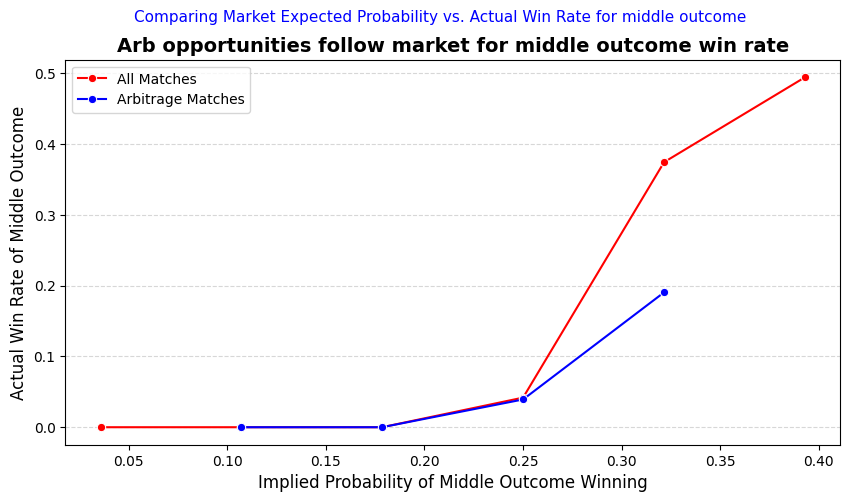

In [184]:

# ---- Identify Middle-Priced Outcome ----
def get_middle_priced_outcome(row):
    odds = {"H": row["max_home"], "A": row["max_away"], "D": row["max_draw"]}
    sorted_outcomes = sorted(odds.items(), key=lambda x: x[1])  # Sort by odds value
    return sorted_outcomes[1][0]  # Middle outcome (2nd in sorted list)

merged_df["middle_outcome"] = merged_df.apply(get_middle_priced_outcome, axis=1)

# ---- Assign Whether the Middle-Priced Outcome Won ----
merged_df["middle_outcome_won"] = merged_df.apply(lambda row: row["FTR"] == row["middle_outcome"], axis=1).astype(int)

# ---- Compute Implied Probability of Middle Outcome ----
merged_df["implied_prob_middle"] = 1 / merged_df[["max_home", "max_away", "max_draw"]].apply(lambda x: sorted(x)[1], axis=1)

# ---- Split Data: Arbitrage Matches vs. All Matches ----
arb_events_df = merged_df[merged_df["arbitrage_margin"] > 0].copy()

# ---- Compute Win Rates by Implied Probability Bins (Using Broader Bins) ----
bins = np.linspace(0, 1, 15)  # 10 bins from 0% to 100% probability for stability
merged_df["implied_prob_bin"] = pd.cut(merged_df["implied_prob_middle"], bins=bins, right=False)
arb_events_df["implied_prob_bin"] = pd.cut(arb_events_df["implied_prob_middle"], bins=bins, right=False)

# Compute win rate per implied probability bin
win_rates_all = merged_df.groupby("implied_prob_bin")["middle_outcome_won"].mean().reset_index()
win_rates_arb = arb_events_df.groupby("implied_prob_bin")["middle_outcome_won"].mean().reset_index()

# Convert bin labels to numeric values (midpoint of range) for plotting
win_rates_all["implied_prob_mid"] = win_rates_all["implied_prob_bin"].apply(lambda x: (x.left + x.right) / 2)
win_rates_arb["implied_prob_mid"] = win_rates_arb["implied_prob_bin"].apply(lambda x: (x.left + x.right) / 2)

# ---- Plot Middle Outcome Win Rate vs. Implied Probability ----
plt.figure(figsize=(10, 5))

# All matches in red
sns.lineplot(x=win_rates_all["implied_prob_mid"], y=win_rates_all["middle_outcome_won"], marker="o", color="red", label="All Matches")

# Arbitrage sample in blue
sns.lineplot(x=win_rates_arb["implied_prob_mid"], y=win_rates_arb["middle_outcome_won"], marker="o", color="blue", label="Arbitrage Matches")

# Formatting
plt.xlabel("Implied Probability of Middle Outcome Winning", fontsize=12)
plt.ylabel("Actual Win Rate of Middle Outcome", fontsize=12)
plt.title("Arb opportunities follow market for middle outcome win rate", fontsize=14, fontweight="bold")
plt.suptitle("Comparing Market Expected Probability vs. Actual Win Rate for middle outcome", fontsize=11, color="blue")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend()

# Save and show plot
plt.savefig("../data/visualisations/arb_betting_strategies/middle_outcome_win_vs_implied_prob.png", bbox_inches="tight")
plt.show()


C:\Users\jogim\AppData\Local\Temp\ipykernel_13232\1905095041.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  win_rates_all_underdog = merged_df.groupby("implied_prob_underdog_bin")["underdog_won_or_draw"].mean().reset_index()
C:\Users\jogim\AppData\Local\Temp\ipykernel_13232\1905095041.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  win_rates_arb_underdog = arb_events_df.groupby("implied_prob_underdog_bin")["underdog_won_or_draw"].mean().reset_index()


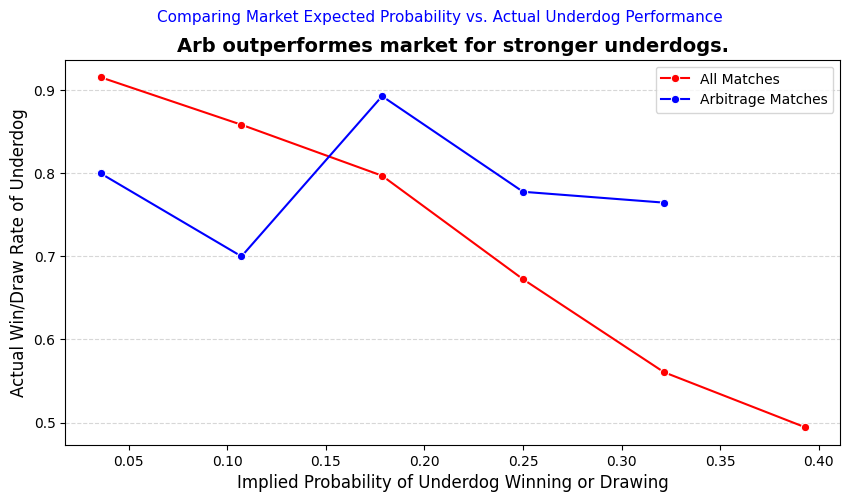

In [185]:
# ---- Compute Implied Probability of Underdog Winning ----
merged_df["implied_prob_underdog"] = 1 / merged_df[["max_home", "max_away"]].max(axis=1)

# ---- Determine Underdog Outcome (Including Draws) ----
merged_df["underdog_outcome"] = merged_df[["max_home", "max_away"]].idxmax(axis=1)  # Selects the team with the highest odds

# Mapping the underdog to match result (including draws)
outcome_mapping = {"max_home": "A", "max_away": "H"}

# Assign whether the underdog won or the match was a draw
merged_df["underdog_won_or_draw"] = merged_df.apply(
    lambda row: (row["FTR"] == outcome_mapping.get(row["underdog_outcome"], None)) or (row["FTR"] == "D"),
    axis=1
).astype(int)

# ---- Split Data: Arbitrage Matches vs. All Matches ----
arb_events_df = merged_df[merged_df["arbitrage_margin"] > 0].copy()

# ---- Compute Win Rates by Implied Probability Bins ----
bins = np.linspace(0, 1, 15)  # 15 bins for better stability
merged_df["implied_prob_underdog_bin"] = pd.cut(merged_df["implied_prob_underdog"], bins=bins, right=False)
arb_events_df["implied_prob_underdog_bin"] = pd.cut(arb_events_df["implied_prob_underdog"], bins=bins, right=False)

# Compute win rate per implied probability bin
win_rates_all_underdog = merged_df.groupby("implied_prob_underdog_bin")["underdog_won_or_draw"].mean().reset_index()
win_rates_arb_underdog = arb_events_df.groupby("implied_prob_underdog_bin")["underdog_won_or_draw"].mean().reset_index()

# Convert bin labels to numeric values (midpoint of range) for plotting
win_rates_all_underdog["implied_prob_mid"] = win_rates_all_underdog["implied_prob_underdog_bin"].apply(lambda x: (x.left + x.right) / 2)
win_rates_arb_underdog["implied_prob_mid"] = win_rates_arb_underdog["implied_prob_underdog_bin"].apply(lambda x: (x.left + x.right) / 2)

# ---- Plot Underdog Win Rate (Including Draws) vs. Implied Probability ----
plt.figure(figsize=(10, 5))

# All matches in red
sns.lineplot(x=win_rates_all_underdog["implied_prob_mid"], y=win_rates_all_underdog["underdog_won_or_draw"], marker="o", color="red", label="All Matches")

# Arbitrage sample in blue
sns.lineplot(x=win_rates_arb_underdog["implied_prob_mid"], y=win_rates_arb_underdog["underdog_won_or_draw"], marker="o", color="blue", label="Arbitrage Matches")

# Formatting
plt.xlabel("Implied Probability of Underdog Winning or Drawing", fontsize=12)
plt.ylabel("Actual Win/Draw Rate of Underdog", fontsize=12)
plt.title("Arb outperformes market for stronger underdogs.", fontsize=14, fontweight="bold")
plt.suptitle("Comparing Market Expected Probability vs. Actual Underdog Performance", fontsize=11, color="blue")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend()

# Save and show plot
plt.savefig("../data/visualisations/arb_betting_strategies/underdog_win_draw_vs_implied_prob.png", bbox_inches="tight")
plt.show()


### Insights:

From the 3 graphs below we can infer that arbitrage events has higher sucess rates compared to the market when: i.) there is a weak favourite ii.) there is a strong underdog

There aren't any singificant trends indicating arbitrage outcomes are any more probable than the aggregate market for the 2nd best outcome, for when the likelyhood of the 2nd outcome is strong, arbitrage opportunties prevail at a rate much lower than the market average.

I am going to be using this to be informing biased arbitrage back

    

---
# 9.) Backtesting unbiased arb strategy:

Now I am going to begin backtesting a basic unbiased arbitrage strategy, for this I will create a function to plot unbiased arb events

C:\Users\jogim\AppData\Local\Temp\ipykernel_13232\3224687532.py:5: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  arb_events_df["Date"] = pd.to_datetime(arb_events_df["Date"])


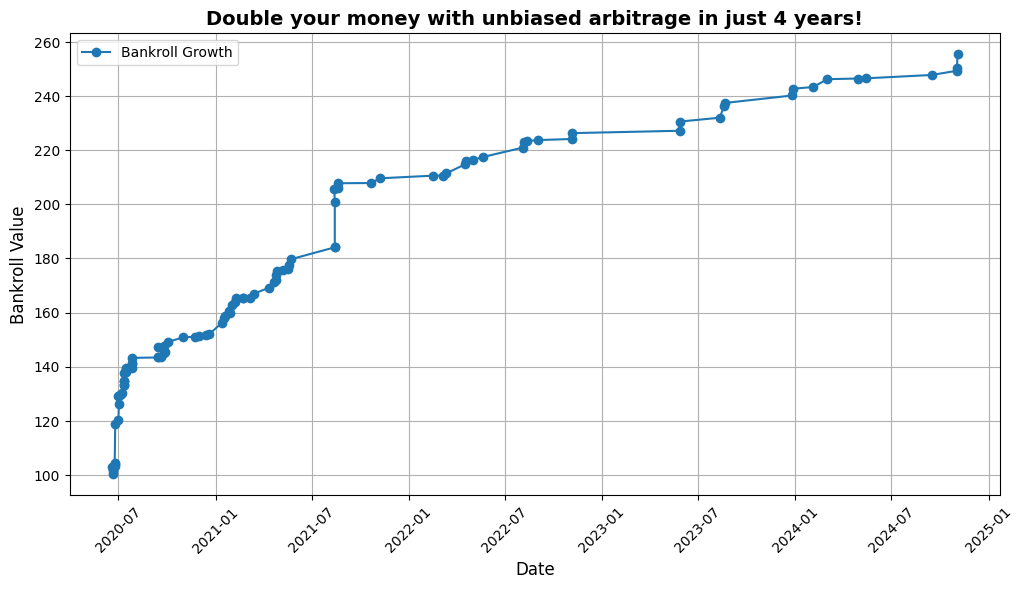

In [186]:

def simulate_unbiased_arb(arb_events_df, starting_bankroll, start_date, end_date):


    # Convert Date column to datetime
    arb_events_df["Date"] = pd.to_datetime(arb_events_df["Date"])

    # Filter data for the specified time period
    filtered_df = arb_events_df[(arb_events_df["Date"] >= start_date) & (arb_events_df["Date"] <= end_date)].copy()

    # Ensure the required columns exist
    required_columns = {"Date", "max_home", "max_away", "max_draw", "FTR"}
    if not required_columns.issubset(filtered_df.columns):
        raise ValueError(f"Missing required columns: {required_columns - set(filtered_df.columns)}")

    # Initialize bankroll
    bankroll = starting_bankroll
    bankroll_history = []

    # Loop through arbitrage opportunities and simulate bets
    for _, row in filtered_df.iterrows():
        # Compute arbitrage stake allocation for equal profit
        odds = [row["max_home"], row["max_away"], row["max_draw"]]
        total_investment = sum(1 / np.array(odds))

        if total_investment >= 1:  # No guaranteed profit, skip bet
            continue

        # Update stake for this round (entire bankroll)
        stake_per_bet = bankroll

        # Allocate stake based on arbitrage odds (ensures equal profit)
        stake_allocation = (stake_per_bet / total_investment) * (1 / np.array(odds))
        total_stake = sum(stake_allocation)

        # Determine bet outcome
        if row["FTR"] == "H":
            profit = (stake_allocation[0] * row["max_home"]) - total_stake
        elif row["FTR"] == "A":
            profit = (stake_allocation[1] * row["max_away"]) - total_stake
        else:  # Draw outcome
            profit = (stake_allocation[2] * row["max_draw"]) - total_stake

        # Update bankroll (compounded growth)
        bankroll += profit

        # Log bankroll history
        bankroll_history.append([row["Date"], stake_per_bet, profit, bankroll])

    # Convert to DataFrame
    results_df = pd.DataFrame(bankroll_history, columns=["Date", "Bet Placed", "Profit", "Bankroll"])

    # Plot bankroll growth
    plt.figure(figsize=(12, 6))
    plt.plot(results_df["Date"], results_df["Bankroll"], marker="o", linestyle="-", label="Bankroll Growth")
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Bankroll Value", fontsize=12)
    plt.title("Double your money with unbiased arbitrage in just 4 years!", fontsize=14, fontweight="bold")
    plt.legend()
    plt.grid()
    plt.xticks(rotation=45)
    plt.savefig("../data/visualisations/arb_betting_strategies/unbiased_arb_simulation", bbox_inches="tight")
    plt.show()
    

    return results_df

# Example Usage
df_results = simulate_unbiased_arb(arb_events_df, starting_bankroll=100, start_date="2020-06-01", end_date="2025-01-01")




### Insight:

Arb really can make you richer

Although as expected from prior insights, returns have slowed down in recent years

---
# 10.) Backtesting Bias arb strategies

Now I will be comparing the results of unbiased arbitrage to the results of baised arbitrage, firstly I have created a general function called simulate_arb, I will be using this to generate the plots for the 4 different strategies

Then I will use a 2nd written function plot_arbitrage_strategies to plot the results

In [187]:


def simulate_arb(arb_events_df, starting_bankroll, start_date, end_date, bias_type="none"):


    # Convert Date column to datetime
    arb_events_df["Date"] = pd.to_datetime(arb_events_df["Date"])

    # Filter data for the specified time period
    filtered_df = arb_events_df[(arb_events_df["Date"] >= start_date) & (arb_events_df["Date"] <= end_date)].copy()

    # Ensure required columns exist
    required_columns = {"Date", "home_team", "away_team", "FTR", "max_home", "max_away", "max_draw"}
    if not required_columns.issubset(filtered_df.columns):
        raise ValueError(f"Missing required columns: {required_columns - set(filtered_df.columns)}")

    # Initialize bankroll
    bankroll = starting_bankroll
    bankroll_history = []

    # Loop through arbitrage opportunities and simulate bets
    for _, row in filtered_df.iterrows():
        # Extract odds
        odds_home = row["max_home"]
        odds_away = row["max_away"]
        odds_draw = row["max_draw"]

        # Sort outcomes by odds (Favorite has the lowest odds, Underdog has the highest)
        sorted_odds = sorted([("Home", odds_home), ("Away", odds_away), ("Draw", odds_draw)], key=lambda x: x[1])
        
        # Assign labels
        favorite = sorted_odds[0]  # Lowest odds (Favorite)
        second_fav = sorted_odds[1]  # Middle odds (Second Favorite)
        underdog = sorted_odds[2]  # Highest odds (Underdog)

        # Compute total implied probability
        total_investment = (1 / odds_home) + (1 / odds_away) + (1 / odds_draw)

        if total_investment >= 1:  # No guaranteed profit, skip bet
            continue  # Skip non-arbitrage events

        # Compute break-even bankroll allocation (ensures no loss)
        B = bankroll
        P = B / total_investment  # Break-even payout

        # Assign bias event based on user selection
        if bias_type == "none":
            bias_event = None  # No bias
            bias_ftr = None
            bias_odds = None
        else:
            if bias_type == "fav":
                bias_event, bias_odds = favorite
            elif bias_type == "second":
                bias_event, bias_odds = second_fav
            elif bias_type == "underdog":
                bias_event, bias_odds = underdog
            else:
                raise ValueError("Invalid bias_type. Choose from 'none', 'fav', 'second', or 'underdog'.")

            # Convert bias event to match FTR (H, A, D)
            bias_ftr_map = {"Home": "H", "Away": "A", "Draw": "D"}
            bias_ftr = bias_ftr_map[bias_event]

        # Compute break-even stakes
        stake_home = P / odds_home
        stake_away = P / odds_away
        stake_draw = P / odds_draw

        # If bias is applied, reallocate extra stake to the biased event
        if bias_type != "none":
            extra_stake = B - (stake_home + stake_away + stake_draw)

            if bias_event == "Home":
                stake_home += extra_stake
            elif bias_event == "Away":
                stake_away += extra_stake
            else:
                stake_draw += extra_stake

        # Compute total stake placed
        total_stake = stake_home + stake_away + stake_draw

        # Compute correct profit
        if bias_type == "none":  # Unbiased arbitrage (profit is equal across all outcomes)
            profit = P - total_stake  # Profit is the guaranteed arbitrage return
        else:  # Biased arbitrage (profit only occurs when the biased event wins)
            if bias_event == "Home":
                stake_bias = stake_home
            elif bias_event == "Away":
                stake_bias = stake_away
            else:
                stake_bias = stake_draw

            profit_if_biased_event_occurs = (stake_bias * bias_odds) - total_stake
            profit = profit_if_biased_event_occurs if row["FTR"] == bias_ftr else 0

        # Update bankroll
        bankroll += profit

        # Log bankroll history
        bankroll_history.append([row["Date"], bankroll, profit, stake_home, stake_away, stake_draw])

    # Convert to DataFrame
    results_df = pd.DataFrame(bankroll_history, columns=["Date", "Bankroll", "Profit", "Stake_Home", "Stake_Away", "Stake_Draw"])

    return results_df  

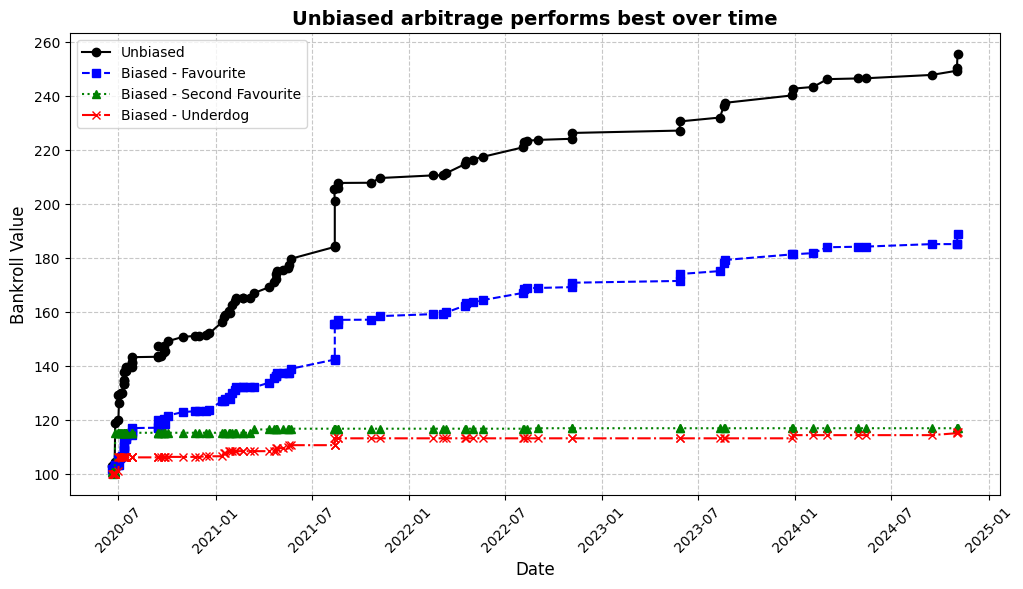

In [188]:
def plot_arbitrage_strategies(arb_events_df, starting_bankroll, start_date, end_date):

    # Run simulations for each strategy
    strategies = {
        "Unbiased": "none",
        "Biased - Favourite": "fav",
        "Biased - Second Favourite": "second",
        "Biased - Underdog": "underdog"
    }
    
    results = {}

    for name, bias_type in strategies.items():
        results[name] = simulate_arb(arb_events_df, starting_bankroll, start_date, end_date, bias_type)
    
    # Create the plot
    plt.figure(figsize=(12, 6))

    # Define colors and markers for each strategy
    colors = {
        "Unbiased": "black",
        "Biased - Favourite": "blue",
        "Biased - Second Favourite": "green",
        "Biased - Underdog": "red"
    }

    markers = {
        "Unbiased": "o",
        "Biased - Favourite": "s",
        "Biased - Second Favourite": "^",
        "Biased - Underdog": "x"
    }

    linestyles = {
        "Unbiased": "-",
        "Biased - Favourite": "--",
        "Biased - Second Favourite": ":",
        "Biased - Underdog": "-."
    }

    # Plot bankroll growth for each strategy
    for name, df in results.items():
        plt.plot(df["Date"], df["Bankroll"], color=colors[name], label=name, linestyle=linestyles[name], marker=markers[name])

    # Format the plot
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Bankroll Value", fontsize=12)
    plt.title("Unbiased arbitrage performs best over time", fontsize=14, fontweight="bold")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.xticks(rotation=45)
    plt.savefig("../data/visualisations/arb_betting_strategies/arbitrage_strategies_comparison.png", bbox_inches="tight")

    # Show only the final combined plot
    plt.show()


plot_arbitrage_strategies(
    arb_events_df, 
    starting_bankroll=100, 
    start_date="2020-06-01", 
    end_date="2025-01-01"
)


### Insight:

This is likely to be due to the consistent and regular nature of profits meaning that is is easier for profits to compound over time, and this effect outweighs the effect of biased arbitrage offering higher profits less frequently. (as it only pays out if the bias event occurs)

Nontheless I still belive I can find an edge over unbiased arbitrage If I create a custom strategy...

---
# 11.) Creation of a custom strategy

Now I will be creating a custom strategy based on my prior insights from part 8.) of the notebook, 

Note its important to make sure that data leakage isn't occuring but this is hard due to the revelaed knowledge I have from my prior EDA

To counterract this I will try to keep my strategies generalised thus still applicable within error, and therefore results and profits wont be too 'cherry picked'

This custom strategy will essentially be deciding to engage in biased vs unbiased behaviour based on the insights from part 8.) 

if there is a strong underdog, biased arb
if there is a weak favourite, then biased arb 
if both exist then unbiased arb
if neither exist, unbiased arb
it is XOR logic

In [189]:


def custom_arb(arb_events_df, starting_bankroll, start_date, end_date):

    # Convert Date column to datetime
    arb_events_df["Date"] = pd.to_datetime(arb_events_df["Date"])

    # Filter data for the specified time period
    filtered_df = arb_events_df[(arb_events_df["Date"] >= start_date) & (arb_events_df["Date"] <= end_date)].copy()

    # Ensure required columns exist
    required_columns = {"Date", "home_team", "away_team", "FTR", "max_home", "max_away", "max_draw"}
    if not required_columns.issubset(filtered_df.columns):
        raise ValueError(f"Missing required columns: {required_columns - set(filtered_df.columns)}")

    # Initialize bankroll
    bankroll = starting_bankroll
    bankroll_history = []

    # Loop through arbitrage opportunities and simulate bets
    for _, row in filtered_df.iterrows():
        # Extract odds
        odds_home = row["max_home"]
        odds_away = row["max_away"]
        odds_draw = row["max_draw"]

        # Compute implied probabilities
        implied_home = 1 / odds_home
        implied_away = 1 / odds_away
        implied_draw = 1 / odds_draw

        # Sort outcomes by odds (Favorite has the lowest odds, Underdog has the highest)
        sorted_odds = sorted([("Home", odds_home, implied_home), 
                              ("Away", odds_away, implied_away), 
                              ("Draw", odds_draw, implied_draw)], key=lambda x: x[1])
        
        # Assign labels
        favorite = sorted_odds[0]  # Lowest odds (Favorite)
        second_fav = sorted_odds[1]  # Middle odds (Second Favorite)
        underdog = sorted_odds[2]  # Highest odds (Underdog)

        # Retrieve implied probabilities for favorite and underdog
        fav_implied_prob = favorite[2]
        underdog_implied_prob = underdog[2]

        # Determine dynamic bias per bet
        if underdog_implied_prob > 0.2 and fav_implied_prob < 0.6:
            bias_type = "none"  # Unbiased if both conditions are met
        elif underdog_implied_prob > 0.2:
            bias_type = "underdog"
        elif fav_implied_prob < 0.6:
            bias_type = "fav"
        else:
            bias_type = "none"  # Unbiased if neither condition is met

        # Compute total implied probability
        total_investment = (1 / odds_home) + (1 / odds_away) + (1 / odds_draw)

        if total_investment >= 1:  # No guaranteed profit, skip bet
            continue  # Skip non-arbitrage events

        # Compute break-even bankroll allocation (ensures no loss)
        B = bankroll
        P = B / total_investment  # Break-even payout

        # Assign bias event
        if bias_type == "none":
            bias_event = None  # No bias
            bias_ftr = None
            bias_odds = None
        else:
            if bias_type == "fav":
                bias_event, bias_odds = favorite[:2]
            elif bias_type == "underdog":
                bias_event, bias_odds = underdog[:2]
            else:
                raise ValueError("Invalid bias_type selection")

            # Convert bias event to match FTR (H, A, D)
            bias_ftr_map = {"Home": "H", "Away": "A", "Draw": "D"}
            bias_ftr = bias_ftr_map[bias_event]

        # Compute break-even stakes
        stake_home = P / odds_home
        stake_away = P / odds_away
        stake_draw = P / odds_draw

        # If bias is applied, reallocate extra stake to the biased event
        if bias_type != "none":
            extra_stake = B - (stake_home + stake_away + stake_draw)

            if bias_event == "Home":
                stake_home += extra_stake
            elif bias_event == "Away":
                stake_away += extra_stake
            else:
                stake_draw += extra_stake

        # Compute total stake placed
        total_stake = stake_home + stake_away + stake_draw

        # Compute correct profit
        if bias_type == "none":  # Unbiased arbitrage (profit is equal across all outcomes)
            profit = P - total_stake  # Profit is the guaranteed arbitrage return
        else:  # Biased arbitrage (profit only occurs when the biased event wins)
            if bias_event == "Home":
                stake_bias = stake_home
            elif bias_event == "Away":
                stake_bias = stake_away
            else:
                stake_bias = stake_draw

            profit_if_biased_event_occurs = (stake_bias * bias_odds) - total_stake
            profit = profit_if_biased_event_occurs if row["FTR"] == bias_ftr else 0

        # Update bankroll
        bankroll += profit

        # Log bankroll history
        bankroll_history.append([row["Date"], bankroll, profit, stake_home, stake_away, stake_draw, bias_type])

    # Convert to DataFrame
    results_df = pd.DataFrame(bankroll_history, columns=["Date", "Bankroll", "Profit", "Stake_Home", "Stake_Away", "Stake_Draw", "Bias_Type"])

    return results_df  # Returns results for visualization


Visualisation:

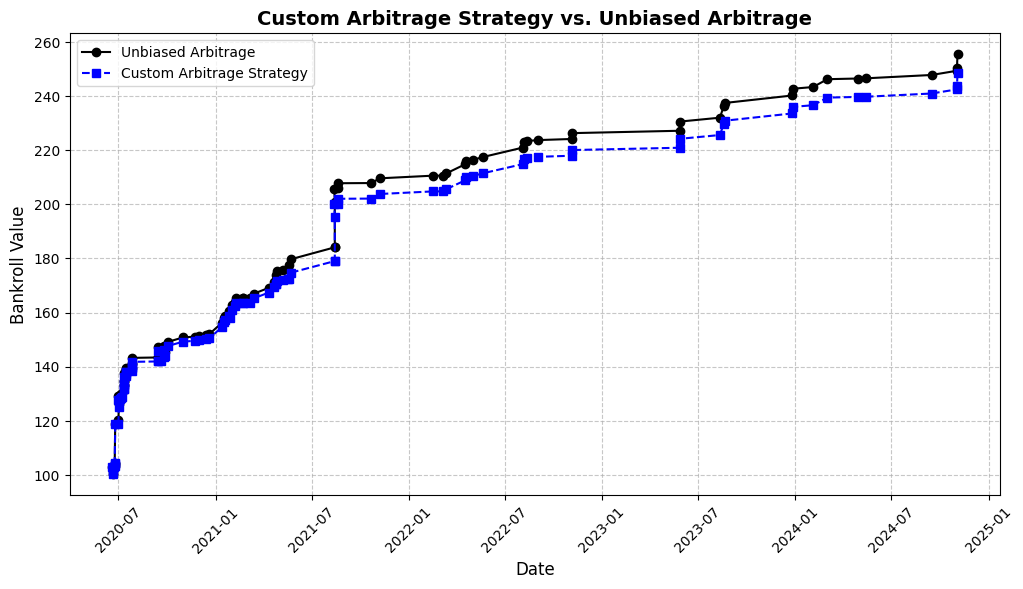

In [190]:


def plot_custom_vs_unbiased(arb_events_df, starting_bankroll, start_date, end_date):
    """
    Runs the custom strategy vs. unbiased arbitrage and visualizes bankroll growth.
    """

    # Run both strategies
    df_unbiased = simulate_arb(arb_events_df, starting_bankroll, start_date, end_date, bias_type="none")
    df_custom = custom_arb(arb_events_df, starting_bankroll, start_date, end_date)

    # Create the plot
    plt.figure(figsize=(12, 6))

    # Plot bankroll growth for each strategy
    plt.plot(df_unbiased["Date"], df_unbiased["Bankroll"], color="black", label="Unbiased Arbitrage", linestyle="-", marker="o")
    plt.plot(df_custom["Date"], df_custom["Bankroll"], color="blue", label="Custom Arbitrage Strategy", linestyle="--", marker="s")

    # Format the plot
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Bankroll Value", fontsize=12)
    plt.title("Custom Arbitrage Strategy vs. Unbiased Arbitrage", fontsize=14, fontweight="bold")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.xticks(rotation=45)
    plt.savefig("../data/visualisations/arb_betting_strategies/custom_vs_unbiased_arb_comparison.png", bbox_inches="tight")

    # Show the plot
    plt.show()

# Example Usage
plot_custom_vs_unbiased(arb_events_df, 100, "2020-06-01", "2025-01-01")


---
# 12.) Conclusion

Ultimately I have uncovered more about the nature of arbitrage, especially that it is more prevalent at the start of seasons, and although is declining in prevalence, opportunities still occur.

We also did a basic analysis of how arb events differ from the other events in the sample

We learned that arb events usually tend to have a higher odds difference (thus a clear winner)

We also learned that arb events tend to occur at a greater frequency than implied when i.) there is a weak favourite ii.) there is a strong underdog.

Then We began to backtested strategies involving arbitrage. Although underwhelming it showed that **UNBIASED ARBITRAGE ALWAYS PREVAILS**

